In [1]:
# Imports and constants
import pandas as pd
from sqlalchemy.sql import text
from lib import Output, TaxiDBReader, GREEN, YELLOW, TABLES, tabulate, CHUNK_SIZE, TABLE_FORMAT, SEPARATOR, DR, getDF, COLUMNS, normalizedColumns, runSql, ALL_COLUMNS

O = Output('output/ppt_output.txt') 
    
# O.clear()
# O.out(SEPARATOR)
# O.out('DS Capstone')
# O.out(SEPARATOR)



sql engine ready


In [2]:
# ctables = [
#     (GREEN, 2023), 
#     (YELLOW, 2023)
# ]

for t in TABLES:
# for t in ctables:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    O.out(f'table: {table_name}')
    uniq_table_name = DR.getTableName('uniq_')

    # of trips by month
    sql = text(f'''
    SELECT COUNT(1) as num_trips, (strftime('%Y-%m', pickup_datetime)) as month 
    FROM {uniq_table_name}
    WHERE CAST(strftime('%Y', pickup_datetime) AS integer)={year}
    GROUP BY month
    ORDER BY num_trips DESC
''')
    df = getDF(sql)
    O.out(df, True)

    O.out(SEPARATOR)

In [15]:
# deleting outliers - rows where location ids are not present in taxi zones
# pu_location_id', 'do_location_id
# pickup_datetime', 'dropoff_datetime
def getSqls(table_name):
    return [
        ('Deleted rows with invalid location ids: ', f'DELETE FROM {table_name} WHERE pu_location_id NOT IN (SELECT location_id FROM taxi_zones) OR do_location_id NOT IN (SELECT location_id FROM taxi_zones)'),
        ('Deleted rows with trip duration is negative, zero or > 8000 seconds: ', f'DELETE FROM {table_name} WHERE pickup_datetime >= dropoff_datetime OR (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) > 8000'),
        ('Deleted rows with trip distance > 20 miles: ', f'DELETE FROM {table_name} WHERE f_trip_distance > 20'),
        ('Deleted rows with total amount > 100 USD: ', f'DELETE FROM {table_name} WHERE f_total_amount > 100'),
    ]

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    O.out(f'table: {table_name}')
    uniq_table_name = DR.getTableName('uniq_')

    queries = getSqls(uniq_table_name)
    for (m, sql) in queries:
        res = runSql(text(sql), True)
        O.out(f'{m} {res.rowcount}')

    O.out(SEPARATOR)





In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plotNegPos(categories, values):
    # Width of each bar
    width = 0.35

    # Create an array of x positions for the bars
    x = np.arange(len(categories))

    # Create the figure and axes
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(9)

    # Plot the first set of bars
    rects1 = ax.bar(x - width/2, values['neg'], width, label='Negative')

    # Plot the second set of bars
    rects2 = ax.bar(x + width/2, values['pos'], width, label='Positive')

    # Add labels and titles
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Values')
    ax.set_title('Positive vs Negative Values')
    ax.legend()

    # Show the plot
    plt.show()

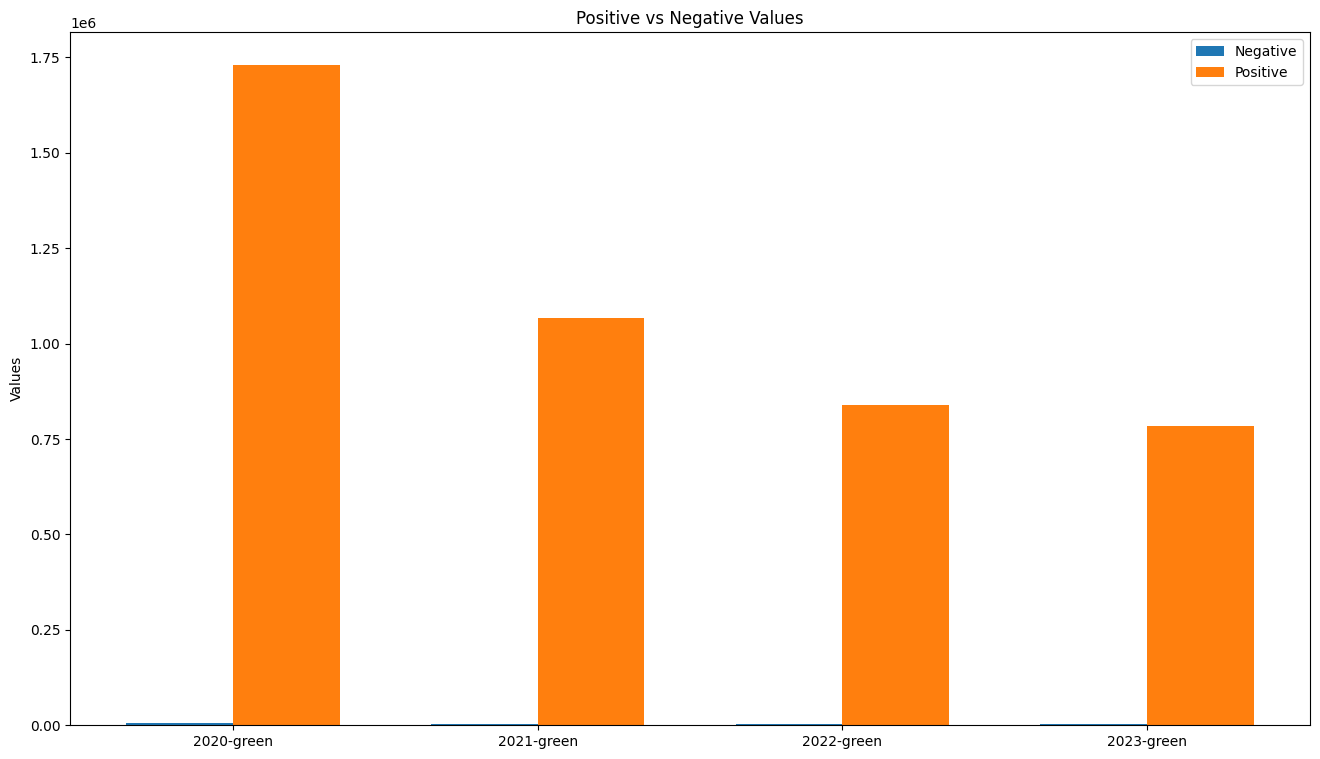

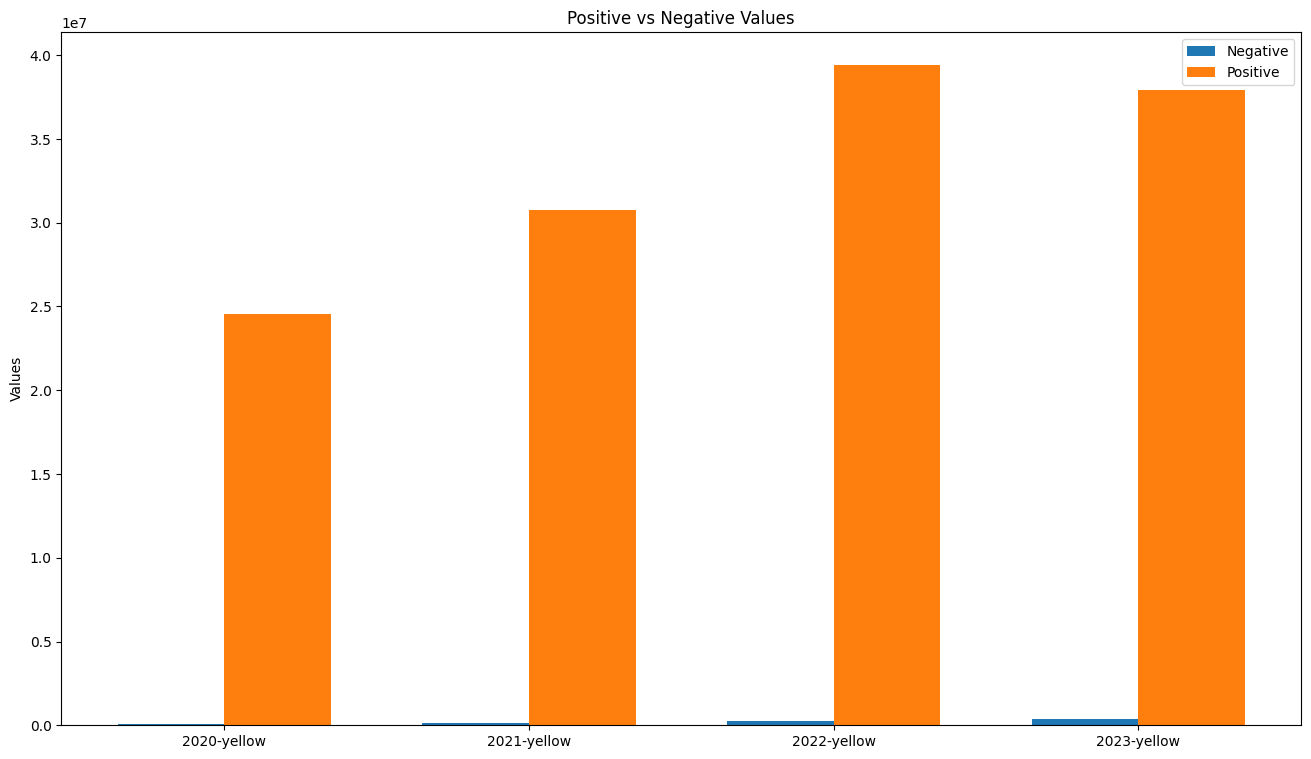

In [6]:
# ctables = [(GREEN, 2023)]

numericals = [
    'passenger_count', 'trip_distance', 'total_amount',
    'fare_amount', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 'improvement_surcharge', 'congestion_surcharge',
]

def posClause():
    conditions = []
    for i,c in enumerate(numericals):
        if (i+1) % 4 == 0:
            conditions.append(f'\n\t\t{c} >= 0')
        else:
            conditions.append(f'{c} >= 0')
    return " AND ".join(conditions)

def negClause():
    conditions = []
    for i,c in enumerate(numericals):
        if (i+1) % 4 == 0:
            conditions.append(f'\n\t\t{c} < 0')
        else:
            conditions.append(f'{c} < 0')
    return " OR ".join(conditions)

cats = {'green': [], 'yellow': []}
vals = {'green': {'neg': [], 'pos': []}, 'yellow': {'neg': [], 'pos': []}}

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    O.out(f'table name: {table_name}')

    O.out(f'Negative values analysis')
    O.out(SEPARATOR)
    
    sql = text(f'''
    SELECT 
        (SELECT COUNT(1) FROM {table_name} WHERE {posClause()}) as pos,
        (SELECT COUNT(1) FROM {table_name} WHERE {negClause()}) as neg
''')
    # print(sql)
    O.out(sql)
    df = getDF(sql)
    O.out(df, True)

    cats[taxi_type].append(f'{year}-{taxi_type}')
    vals[taxi_type]['neg'].append(df['neg'].iloc[0])
    vals[taxi_type]['pos'].append(df['pos'].iloc[0])

plotNegPos(cats[GREEN], vals[GREEN])
plotNegPos(cats[YELLOW], vals[YELLOW])



In [13]:
for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()

    res = runSql(text(f'''
    SELECT COUNT(1) FROM {table_name}
'''))

    O.out(f'table name: {table_name}')
    O.out(f'# of rows: {res.scalar()}')
    O.out(SEPARATOR)

In [10]:
# count zero and negative values

numericals = [
    'passenger_count', 'trip_distance', 'total_amount',
    'fare_amount', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 'improvement_surcharge', 'congestion_surcharge',
]

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    zeroresults = []
    negresults = []
    O.out(f'table name: {table_name}')

    for col in numericals:

        res = runSql(text(f'''
    SELECT COUNT(1) FROM {table_name} WHERE {col}=0
'''))
        # O.out(f'#rows where {col}=0: {res.scalar()}')
        zeroresults.append(res.scalar())

        res = runSql(text(f'''
    SELECT COUNT(1) FROM {table_name} WHERE {col}<0
'''))
        negresults.append(res.scalar())

    O.out(tabulate({'Columns': numericals, 'Negative': negresults, 'Zero': zeroresults}, headers=['Columns', 'Negative', 'Zero']))
    O.out(SEPARATOR)

In [11]:
# delete negative negative

numericals = [
    'passenger_count', 'trip_distance', 'total_amount',
    'fare_amount', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 'improvement_surcharge', 'congestion_surcharge',
]

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    uniq_table_name = DR.getTableName('uniq_')
    negresults = []
    delresults = []
    O.out(f'table name: {table_name}')
    deleted_count = 0
    for col in numericals:  
        sql = text(f'''
    DELETE FROM {uniq_table_name} WHERE {col}<0
''')
        delres = runSql(sql, commit=True)
        deleted_count += delres.rowcount
    
    O.out(f'Total Number of rows with negative values deleted: {deleted_count}')
    O.out(SEPARATOR)

In [10]:
# Delete duplicates

# use COLUMNS
# def getClause(table_name):
#     conditions = []
#     for c in COLUMNS:
#         conditions.append(f'{table_name}.{c} = t2.{c}')
#     return " AND ".join(conditions)

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    O.out(f'table name: {table_name}')

    sql = text(f'''
        DELETE FROM {table_name}
        WHERE ROWID NOT IN (
            SELECT MIN(ROWID)
            FROM green_taxi_trips2020
            GROUP BY {', '.join(COLUMNS)}
        );
    ''')
    # res = runSql(sql)
    O.out(sql)
    
    O.out(f'Total Number of rows with duplicate values deleted: {res.rowcount}')
    O.out(SEPARATOR)



In [7]:
# Delete duplicates ALT ALT ALT

# ctables = [(GREEN, 2023)]

for t in TABLES:
# for t in ctables:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    uniq_table_name = DR.getTableName('uniq_')
    O.out(f'table name: {table_name}')

    sql = text(f'''
    CREATE TABLE IF NOT EXISTS {uniq_table_name} AS SELECT DISTINCT {', '.join(ALL_COLUMNS)} FROM {table_name};
    ''')
    res = runSql(sql, commit=True)
    O.out(sql)
    
    O.out(f'Total Number of rows with duplicate values deleted: {res.rowcount}')
    O.out(SEPARATOR)



In [10]:
# Delete duplicates verification ALT ALT ALT

# ctables = [(GREEN, 2023)]

for t in TABLES:
# for t in ctables:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    table_name = DR.getTableName()
    uniq_table_name = DR.getTableName('uniq_')
    O.out(f'table name: {table_name}')

    sql = text(f'''
    SELECT COUNT(1) FROM {table_name};
    ''')
    # O.out(sql)
    ogres = runSql(sql)
    
    sql = text(f'''
    SELECT COUNT(1) FROM {uniq_table_name};
    ''')
    # O.out(sql)
    uniqres = runSql(sql)
    
    # O.out(f'# of original rows: {ogres.scalar()}, uniq rows: {uniqres.scalar()}')
    O.out(f'Total Number of rows with duplicate values deleted: {ogres.scalar() - uniqres.scalar()}')

In [8]:
# Delete duplicates cleanup ALT ALT ALT

# ctables = [(GREEN, 2023),(YELLOW, 2023)]

for t in TABLES:
    taxi_type, year  = t
    DR.setTable(year, taxi_type)
    # table_name = DR.getTableName()
    uniq_table_name = DR.getTableName('uniq_')
    O.out(f'table name: {uniq_table_name}')

    sql = text(f'''
    DROP TABLE IF EXISTS {uniq_table_name};
    ''')
    O.out(sql)
    res = runSql(sql, commit=True)

    # O.out(f'# {uniq_table_name}: {res.scalar()}')

In [11]:
with DR.engn.connect() as conn:
    # conn.rollback()
    conn.commit()

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# Example data
data = {'amount': [10, 12, 15, 13, 10, 12, 1000, 14, 12, 11, 1001]}
df = pd.DataFrame(data)

# Calculate the Z-scores for the 'amount' column
df['z_score'] = stats.zscore(df['amount'])

# Set a threshold (commonly 3)
threshold = 3

# Identify outliers: rows where the absolute Z-score is greater than the threshold
outliers = df[np.abs(df['z_score']) > threshold]

# Display outliers
print("Outliers based on Z-score:")
print(df)


Outliers based on Z-score:
    amount   z_score
0       10 -0.476939
1       12 -0.471693
2       15 -0.463823
3       13 -0.469069
4       10 -0.476939
5       12 -0.471693
6     1000  2.119993
7       14 -0.466446
8       12 -0.471693
9       11 -0.474316
10    1001  2.122616
